# Reinforcement Learning - Monte Carlo and TD learning

> In this notebook, we will be implementing Monte Carlo control and Temporal difference learning algorithms - Q learning and SARSA algorithms. We will be testing our implementation on CliffWalking environment.

## Importing libs

In [19]:
import gymnasium as gym
from gymnasium.envs.registration import register
from typing import Tuple, List
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv
from gymnasium import spaces
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import pprint

## Timer decorator

In [8]:
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        duration = end - start
        if args and hasattr(args[0], '__dict__'):
            setattr(args[0], f'{func.__name__}_time', duration)
        print(f"Function '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

## Cliff Walking

In [9]:
class CliffWalking:
    def __init__(self, rows: int = 4, cols: int = 12):
        self.rows = rows
        self.cols = cols
        self.start = (rows - 1, 0)
        self.goal = (rows - 1, cols - 1)
        self.cliff = {(rows-1,c) for c in range(1,cols-1)}

        self.actions = {
            0: (-1, 0),  # up
            1: ( 0, 1),  # right
            2: ( 1, 0),  # down
            3: ( 0,-1),  # left
        }

        self.n_actions = len(self.actions)
        self.n_states = rows * cols
        self.reset()

    def state_to_index(self, pos: Tuple[int,int]) -> int:
        r, c = pos
        return r * self.cols + c

    def index_to_state(self, idx: int) -> Tuple[int,int]:
        return divmod(idx, self.cols)

    def reset(self):
        self.agent_pos = self.start
        return self.state_to_index(self.agent_pos), {}

    def step(self, action: int) -> Tuple[int, float, bool, bool, int]:
        if action not in self.actions:
            raise ValueError(f"Invalid action {action}")

        truncated = False

        dr, dc = self.actions[action]
        r, c = self.agent_pos
        new_r = min(max(r + dr, 0), self.rows - 1)
        new_c = min(max(c + dc, 0), self.cols - 1)
        new_pos = (new_r, new_c)

        if new_pos in self.cliff:
            reward = -100.0
            self.agent_pos = self.start
            done = False
        elif new_pos == self.goal:
            reward = -1.0
            self.agent_pos = new_pos
            done = True
        else:
            reward = -1.0
            self.agent_pos = new_pos
            done = False

        next_state = self.state_to_index(self.agent_pos)
        return next_state, reward, done, truncated, {}

## Monte Carlo Implementation

In [10]:
@timer
def monte_carlo(env, episodes=10000, alpha=0.1, discount=0.99, epsilon=0.1):
    """
    Monte Carlo control using first-visit method and epsilon-greedy policy.
    Returns Q table of state-action values.
    """
    n_actions = env.n_actions
    n_states = env.n_states
    max_steps = 1000

    Q = np.zeros((n_states, n_actions)) #q value function initialization

    for ep in tqdm(range(episodes), desc="Monte Carlo"):
        state, _ = env.reset()
        done = False
        episode = []
        steps = 0

        # generating an episode
        while not done and steps < max_steps:
            #exploration
            if random.random() < epsilon:
                action = np.random.choice(n_actions) # choose any action randomly with a probability of epsilon
            else :
                best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten() #listof all actions with the max q return
                action = int(np.random.choice(best_actions)) #choose any one from them randomly

            # perform the chosen action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state,action,reward))
            state = next_state
            steps += 1

        G = 0
        visited = set()
        for t in range(len(episode)-1,-1,-1): # compute return backwards
            s, a, r = episode[t]
            G = discount*G + r # since we are traversing backwards we can discount without keeping track of the number of terms
            if (s, a) not in visited:
                visited.add((s, a))
                # Incremental update
                Q[s, a] += alpha * (G - Q[s, a])


    return Q



## Temporal Difference Implementation

A generic TD update for $Q(s_t, a_t)$ takes the form:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[\text{Target} - Q(s_t, a_t)\right],
$$

where $\alpha$ is a step-size (learning rate), and Target is an estimate of the return just one-step ahead plus estimated future values.

- In **SARSA**, the target is:

$$
r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}),
$$

using the next action $a_{t+1}$ actually chosen by the current policy (**on-policy**).

- In **Q-learning**, the target is:

$$
r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a'),
$$

using the best possible next action according to current $Q$ (**off-policy**, because it imagines following the greedy policy from the next state even if the       behavior policy actually explores).

Summing up:

- **SARSA update**:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)\right].
$$

- **Q-learning update**:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[r_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t)\right].
$$

In both cases, during learning we select actions via an $\epsilon$-greedy policy over current $Q$: with probability $\epsilon$ choose a random action, else choose:

$$
\arg\max_a Q(s, a).
$$

This ensures exploration.


In [11]:
@timer
# -------------------------------------------------
# Q_LEARNING 
# -------------------------------------------------
def q_learning(env, episodes=1000, alpha=0.1, discount=0.99, epsilon=0.1):
    """
    Q-Learning algorithm with epsilon-greedy exploration.
    Returns Q value function
    """
    n_actions = env.n_actions
    n_states = env.n_states
    max_steps = 1000
    Q = np.zeros((n_states, n_actions)) #init q value functions for all pairs

    for ep in tqdm(range(episodes), desc="Q learning"):
        state, _ = env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = np.random.choice(n_actions)
            else:
                best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
                action = int(np.random.choice(best_actions))
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-Learning update (off-policy)
            best_next = 0 if done else np.max(Q[next_state]) # choose the best q of the nest state for updating irrespective of our current policy (off policy)
            Q[state, action] += alpha * (reward + discount * best_next - Q[state, action])
            steps += 1
            state = next_state
    return Q
    

In [12]:
@timer
# -------------------------------------------------
# SARSA 
# -------------------------------------------------
def sarsa(env, episodes=1000, alpha=0.1, discount=0.99, epsilon=0.1):
    """
    SARSA algorithm (on-policy TD control) 
    """
    n_actions = env.n_actions
    n_states = env.n_states
    max_steps = 1000
    Q = np.zeros((n_states, n_actions)) #init q values for all state action pairs

    for ep in tqdm(range(episodes), desc="SARSA"):
        steps = 0
        state, _ = env.reset()

        # Choose initial action (epsilon strategy)
        if random.random() < epsilon:
            action = np.random.choice(n_actions)
        else:
            best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
            action = int(np.random.choice(best_actions))

        
        done = False
        while not done and steps < max_steps:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Choose next action (epsilon-greedy)
            if random.random() < epsilon:
                next_action = np.random.choice(n_actions)
            else:
                best_actions = np.argwhere(Q[next_state] == np.max(Q[next_state])).flatten()
                next_action = int(np.random.choice(best_actions))
            
            # SARSA update (on-policy)
            Q[state, action] += alpha * (reward + discount * Q[next_state, next_action] * (not done) - Q[state, action])
            state, action = next_state, next_action
            steps += 1
            
    return Q

## Policy Evaluation

Testing our policy on the environments and  printing the time for al the algorithms and the average return obtained

In [ ]:
@timer
def evaluate_policy(env, Q, episodes=100, discount=1.0):
    total_return = 0.0
    max_steps = 200
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        G = 0.0
        t = 0
        steps = 0
        while not done and steps < max_steps:
            # Greedy action
            best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
            action = int(np.random.choice(best_actions))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            G += (discount**t) * reward
            t += 1 # keeping track of the power to raise discount with
            state = next_state
            steps += 1
        total_return += G
    avg_return = total_return / episodes
    return avg_return


## Results

In [14]:
env = CliffWalking()

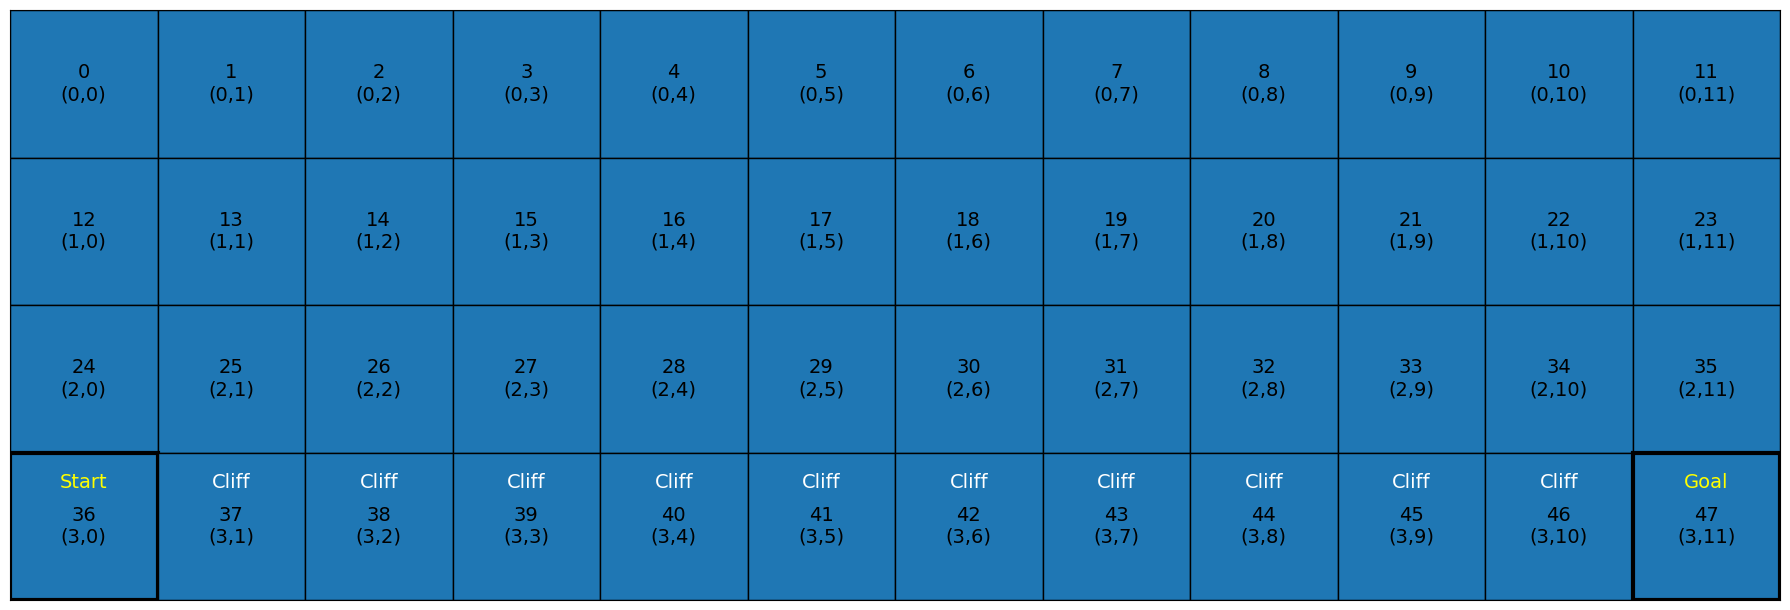

In [24]:
rows, cols = 4, 12
start = (rows - 1, 0)
goal = (rows - 1, cols - 1)
cliff = {(rows - 1, c) for c in range(1, cols - 1)}

# Create figure
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.set_aspect('equal')
ax.invert_yaxis()

# Draw grid cells with annotations
for r in range(rows):
    for c in range(cols):
        rect = plt.Rectangle((c, r), 1, 1, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        idx = r * cols + c
        label = f"{idx}\n({r},{c})"
        ax.text(c + 0.5, r + 0.5, label, ha='center', va='center', fontsize=14)
        
        # Highlight start, goal, and cliff cells
        if (r, c) == start:
            # thicker border for start
            rect = plt.Rectangle((c, r), 1, 1, edgecolor='black', linewidth=3)
            ax.add_patch(rect)
            ax.text(c + 0.5, r + 0.2, "Start", ha='center', va='center', fontsize=14, color='yellow')
        elif (r, c) == goal:
            rect = plt.Rectangle((c, r), 1, 1, edgecolor='black', linewidth=3)
            ax.add_patch(rect)
            ax.text(c + 0.5, r + 0.2, "Goal", ha='center', va='center', fontsize=14, color='yellow')
        elif (r, c) in cliff:
            ax.text(c + 0.5, r + 0.2, "Cliff", ha='center', va='center', fontsize=14, color='white')

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# used chatgpt to generate this function

This is our map of cliff walking environment with state and index respectively and Start, Goal, and Cliff marked. 

In [15]:
mc_Q = monte_carlo(env, episodes=500000, alpha=0.03, discount=0.99, epsilon=0.1)
print("Average Return (MC):", evaluate_policy(env, mc_Q, episodes=1000, discount=0.99))
print()

Monte Carlo:   0%|          | 0/500000 [00:00<?, ?it/s]

Monte Carlo: 100%|██████████| 500000/500000 [03:35<00:00, 2318.60it/s]


Function 'monte_carlo' took 215.6580 seconds
Function 'evaluate_policy' took 0.1713 seconds
Average Return (MC): -13.994164535870876



In [16]:
ql_Q = q_learning(env, episodes=50000, alpha=0.1, discount=0.99, epsilon=0.1)
print("Average Return (Q-Learning):", evaluate_policy(env, ql_Q, episodes=1000, discount=0.99))
print()

Q learning: 100%|██████████| 50000/50000 [00:10<00:00, 4649.00it/s]


Function 'q_learning' took 10.7565 seconds
Function 'evaluate_policy' took 0.1409 seconds
Average Return (Q-Learning): -12.247897700102984



In [18]:
sa_Q = sarsa(env, episodes=500000, alpha=0.1, discount=0.99, epsilon=0.1)
print("Average Return (SARSA):", evaluate_policy(env, sa_Q, episodes=1000, discount=0.99))
print()

SARSA:   0%|          | 0/500000 [00:00<?, ?it/s]

SARSA: 100%|██████████| 500000/500000 [01:48<00:00, 4618.60it/s]


Function 'sarsa' took 108.2611 seconds
Function 'evaluate_policy' took 0.1795 seconds
Average Return (SARSA): -15.705680661607396



Let's see the optimal path found by all the three policies from their q values. 

In [34]:
Q = mc_Q

state, _ = env.reset()
print(f"state : {state} pos : {env.index_to_state(state)}")
done = False
while not done:
    # Greedy action
    best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
    action = int(np.random.choice(best_actions))
    next_state, reward, terminated, truncated, _ = env.step(action)
    print(f"state : {next_state} pos : {env.index_to_state(next_state)}")
    done = terminated or truncated
    state = next_state


state : 36 pos : (3, 0)
state : 24 pos : (2, 0)
state : 25 pos : (2, 1)
state : 13 pos : (1, 1)
state : 14 pos : (1, 2)
state : 15 pos : (1, 3)
state : 16 pos : (1, 4)
state : 17 pos : (1, 5)
state : 18 pos : (1, 6)
state : 19 pos : (1, 7)
state : 20 pos : (1, 8)
state : 21 pos : (1, 9)
state : 22 pos : (1, 10)
state : 23 pos : (1, 11)
state : 35 pos : (2, 11)
state : 47 pos : (3, 11)


In [43]:
Q = ql_Q

state, _ = env.reset()
print(f"state : {state} pos : {env.index_to_state(state)}")
done = False
while not done:
    # Greedy action
    best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
    action = int(np.random.choice(best_actions))
    next_state, reward, terminated, truncated, _ = env.step(action)
    print(f"state : {next_state} pos : {env.index_to_state(next_state)}")
    done = terminated or truncated
    state = next_state


state : 36 pos : (3, 0)
state : 24 pos : (2, 0)
state : 25 pos : (2, 1)
state : 26 pos : (2, 2)
state : 27 pos : (2, 3)
state : 28 pos : (2, 4)
state : 29 pos : (2, 5)
state : 30 pos : (2, 6)
state : 31 pos : (2, 7)
state : 32 pos : (2, 8)
state : 33 pos : (2, 9)
state : 34 pos : (2, 10)
state : 35 pos : (2, 11)
state : 47 pos : (3, 11)


In [40]:
Q = sa_Q

state, _ = env.reset()
print(f"state : {state} pos : {env.index_to_state(state)}")
done = False
while not done:
    # Greedy action
    best_actions = np.argwhere(Q[state] == np.max(Q[state])).flatten()
    action = int(np.random.choice(best_actions))
    next_state, reward, terminated, truncated, _ = env.step(action)
    print(f"state : {next_state} pos : {env.index_to_state(next_state)}")
    done = terminated or truncated
    state = next_state


state : 36 pos : (3, 0)
state : 24 pos : (2, 0)
state : 12 pos : (1, 0)
state : 0 pos : (0, 0)
state : 1 pos : (0, 1)
state : 2 pos : (0, 2)
state : 3 pos : (0, 3)
state : 4 pos : (0, 4)
state : 5 pos : (0, 5)
state : 6 pos : (0, 6)
state : 7 pos : (0, 7)
state : 8 pos : (0, 8)
state : 9 pos : (0, 9)
state : 10 pos : (0, 10)
state : 11 pos : (0, 11)
state : 23 pos : (1, 11)
state : 35 pos : (2, 11)
state : 47 pos : (3, 11)


## Visualization of the path taken by all three algorithms

## Conclusion

We tested all three algorithms on the Cliff Walking experiment and observed the average rewards and the optimal path found by them. We can see that SARSA took the safest path because it is an on-policy method and has no guarantee of choosing the best possible actions again and again. Q learning on the other hand being off policy chooses the path maximizing the return that is the shortest path hugging the cliff. Monte Carlo chooses an inbetween path between them as it is based on the expected returns following a policy so it's neither too far away reducing the reward nor too close reducing the risk of falling into cliff. 